In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from IPython.core.pylabtools import figsize
from scipy.stats import zscore
from scipy import stats
from numpy import percentile

import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

%matplotlib inline
%config InlineBackend.figure_format ='retina'
from pylab import rcParams

from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score

# Features explanation

 **1 - BI-RADS** (Breast Imaging-Reporting and Data System) is a risk assessment and quality assurance tool developed by American College of Radiology that provides a widely accepted lexicon and reporting schema for imaging of the breast
 <br>
**BI-RADS 0**: incomplete
<br>
**BI-RADS 1**: negative = 1.0
<br>
**BI-RADS 2**: benign = 2.0
<br>
**BI-RADS 3**: probably benign (<2% probability of malignancy) = 3.0<br>
**BI-RADS 4**: suspicious for malignancy (2-94% probability of malignancy(4A,4B,4C)) = 4.0  (4A=%2-10,4B=%10-50,4C=%50-92)<br>
**BI-RADS 5**: highly suggestive of malignancy (>92% probability of malignancy) = 5.0<br>
**BI-RADS 6**: known biopsy-proven malignancy 

**2 - Shape** (masses macroscopic view)
<br>
*oval* = 1.0
<br>
*round* = 2.0
<br>
*lobular* = 3.0
<br>
*irregular* = 4.0

**3 - Margin** (Macroscopic view)<br>
*circumscribed* = 1.0<br>
*obscured* = 2.0<br>
*microlobulated* (associated with malignancy) = 3.0<br>
*indistinct* (associated with malignancy) = 4.0<br>
*spiculated* (associated with malignancy) =5.0<br>

**4 - Density**<br>
*high density* (over %78 are malignant) = 1.0<br>
*equal density* = 2.0<br>
*low density* = 3.0<br>
*fat-containing* (almost always benign) = 4.0

**5 - Age** (over 50 yo risk is high)

In [2]:
df=pd.read_csv('mammography.csv', na_values="?")

In [3]:
df.head()

,5,67,3,5.1,3.1,1
0,4.0,43.0,1.0,1.0,NaN,1
1,5.0,58.0,4.0,5.0,3.0,1
2,4.0,28.0,1.0,1.0,3.0,0
3,5.0,74.0,1.0,5.0,NaN,1
4,4.0,65.0,1.0,NaN,3.0,0


In [4]:
df.columns = ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Target']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BI-RADS  958 non-null    float64
 1   Age      955 non-null    float64
 2   Shape    929 non-null    float64
 3   Margin   912 non-null    float64
 4   Density  884 non-null    float64
 5   Target   960 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 45.1 KB


In [6]:
df.isnull().sum()

BI-RADS     2
Age         5
Shape      31
Margin     48
Density    76
Target      0
dtype: int64

In [7]:
df['BI-RADS'].value_counts()

4.0     547
5.0     344
3.0      36
2.0      14
6.0      11
0.0       5
55.0      1
Name: BI-RADS, dtype: int64

In [8]:
bool_series = pd.isnull(df["BI-RADS"])
df[bool_series]

,BI-RADS,Age,Shape,Margin,Density,Target
19,NaN,66.0,NaN,NaN,1.0,1
207,NaN,52.0,4.0,4.0,3.0,0


In [9]:
df[df['BI-RADS']>=6.0]

,BI-RADS,Age,Shape,Margin,Density,Target
339,55.0,46.0,4.0,3.0,3.0,1
549,6.0,80.0,4.0,5.0,3.0,1
663,6.0,60.0,3.0,5.0,3.0,1
691,6.0,51.0,4.0,4.0,3.0,1
706,6.0,41.0,2.0,1.0,3.0,0
716,6.0,71.0,4.0,4.0,3.0,1
717,6.0,68.0,4.0,3.0,3.0,1
744,6.0,76.0,3.0,NaN,3.0,0
783,6.0,63.0,1.0,1.0,3.0,0
823,6.0,40.0,NaN,3.0,4.0,1


In [10]:
df.iloc[339,0]  # In Box plot , we saw that raw is an extreme outlier, so we have to fix this

55.0

In [11]:
df.iloc[19,0]=5.0
df.iloc[339,0]=5.0
df.iloc[207,0]=1.0

In [12]:
bool_series = pd.isnull(df["Age"])
df[bool_series]

,BI-RADS,Age,Shape,Margin,Density,Target
442,4.0,NaN,4.0,5.0,3.0,1
452,5.0,NaN,4.0,4.0,3.0,1
682,5.0,NaN,3.0,3.0,3.0,1
883,5.0,NaN,4.0,4.0,3.0,1
922,5.0,NaN,4.0,3.0,3.0,1


In [13]:
df.iloc[442,1]=64.0
df.iloc[452,1]=65.0
df.iloc[682,1]=69.0
df.iloc[883,1]=67.0
df.iloc[922,1]=70.0

In [14]:
bool_series = pd.isnull(df["Shape"])
df[bool_series]

,BI-RADS,Age,Shape,Margin,Density,Target
5,4.0,70.0,NaN,NaN,3.0,0
8,5.0,60.0,NaN,5.0,1.0,1
19,5.0,66.0,NaN,NaN,1.0,1
47,2.0,42.0,NaN,NaN,4.0,0
53,4.0,53.0,NaN,5.0,3.0,1
73,5.0,70.0,NaN,4.0,NaN,1
82,4.0,57.0,NaN,4.0,1.0,0
127,4.0,52.0,NaN,4.0,NaN,0
156,4.0,51.0,NaN,NaN,3.0,0
162,4.0,53.0,NaN,4.0,3.0,0


In [15]:
df.Shape.value_counts()

4.0    400
1.0    224
2.0    211
3.0     94
Name: Shape, dtype: int64

In [16]:
df.Density.value_counts()

3.0    797
2.0     59
1.0     16
4.0     12
Name: Density, dtype: int64

In [17]:
bool_series = pd.isnull(df["Density"])
df[bool_series]

,BI-RADS,Age,Shape,Margin,Density,Target
0,4.0,43.0,1.0,1.0,NaN,1
3,5.0,74.0,1.0,5.0,NaN,1
18,4.0,40.0,1.0,NaN,NaN,0
21,4.0,43.0,1.0,NaN,NaN,0
25,2.0,66.0,1.0,1.0,NaN,0
...,...,...,...,...,...,...
613,3.0,46.0,NaN,5.0,NaN,1
626,4.0,57.0,2.0,1.0,NaN,0
664,4.0,27.0,2.0,1.0,NaN,0
676,4.0,57.0,4.0,4.0,NaN,1


In [18]:
df.drop('Density', axis=1, inplace=True) # with or w/o Density , my models scores doesn't change

In [19]:
df.head()

,BI-RADS,Age,Shape,Margin,Target
0,4.0,43.0,1.0,1.0,1
1,5.0,58.0,4.0,5.0,1
2,4.0,28.0,1.0,1.0,0
3,5.0,74.0,1.0,5.0,1
4,4.0,65.0,1.0,NaN,0


In [20]:
df.isnull().sum()

BI-RADS     0
Age         0
Shape      31
Margin     48
Target      0
dtype: int64

In [21]:
df = df.dropna()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 959
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BI-RADS  891 non-null    float64
 1   Age      891 non-null    float64
 2   Shape    891 non-null    float64
 3   Margin   891 non-null    float64
 4   Target   891 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 41.8 KB


## EDA

In [23]:
df.describe()

,BI-RADS,Age,Shape,Margin,Target
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,4.312009,55.473625,2.750842,2.767677,0.474747
std,0.694490,14.641795,1.242816,1.568263,0.499642
min,0.000000,18.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,1.000000
max,6.000000,96.000000,4.000000,5.000000,1.000000


In [24]:
rcParams['figure.figsize'] = 12, 9

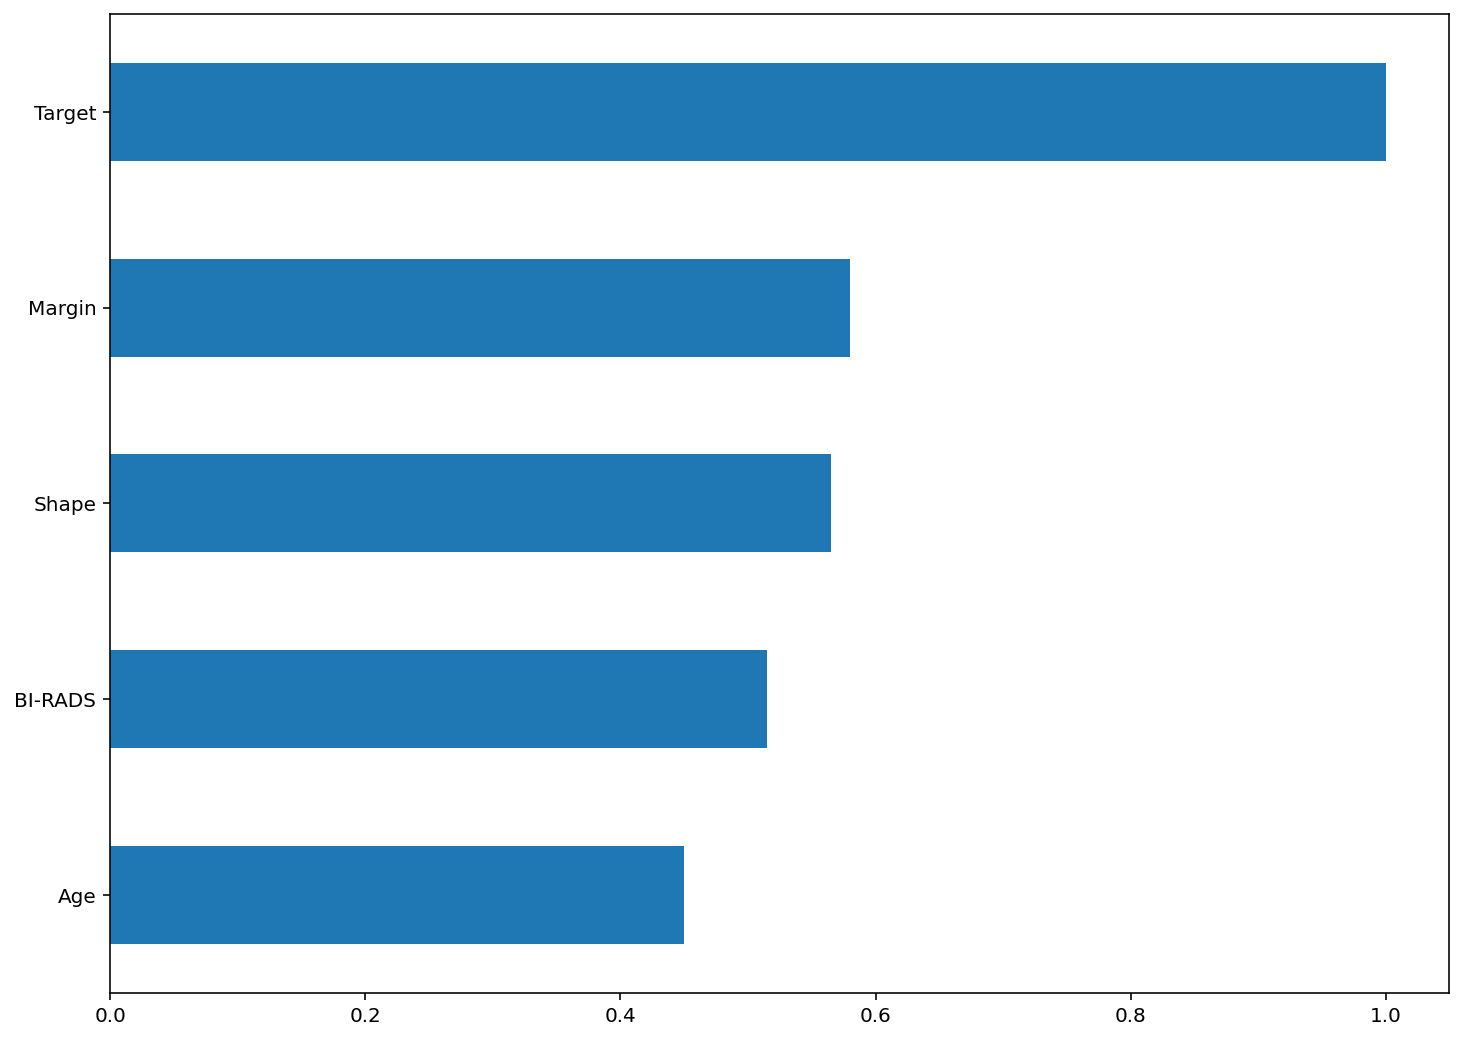

In [25]:
df.corr()['Target'].sort_values().plot.barh(figsize=(12,9));

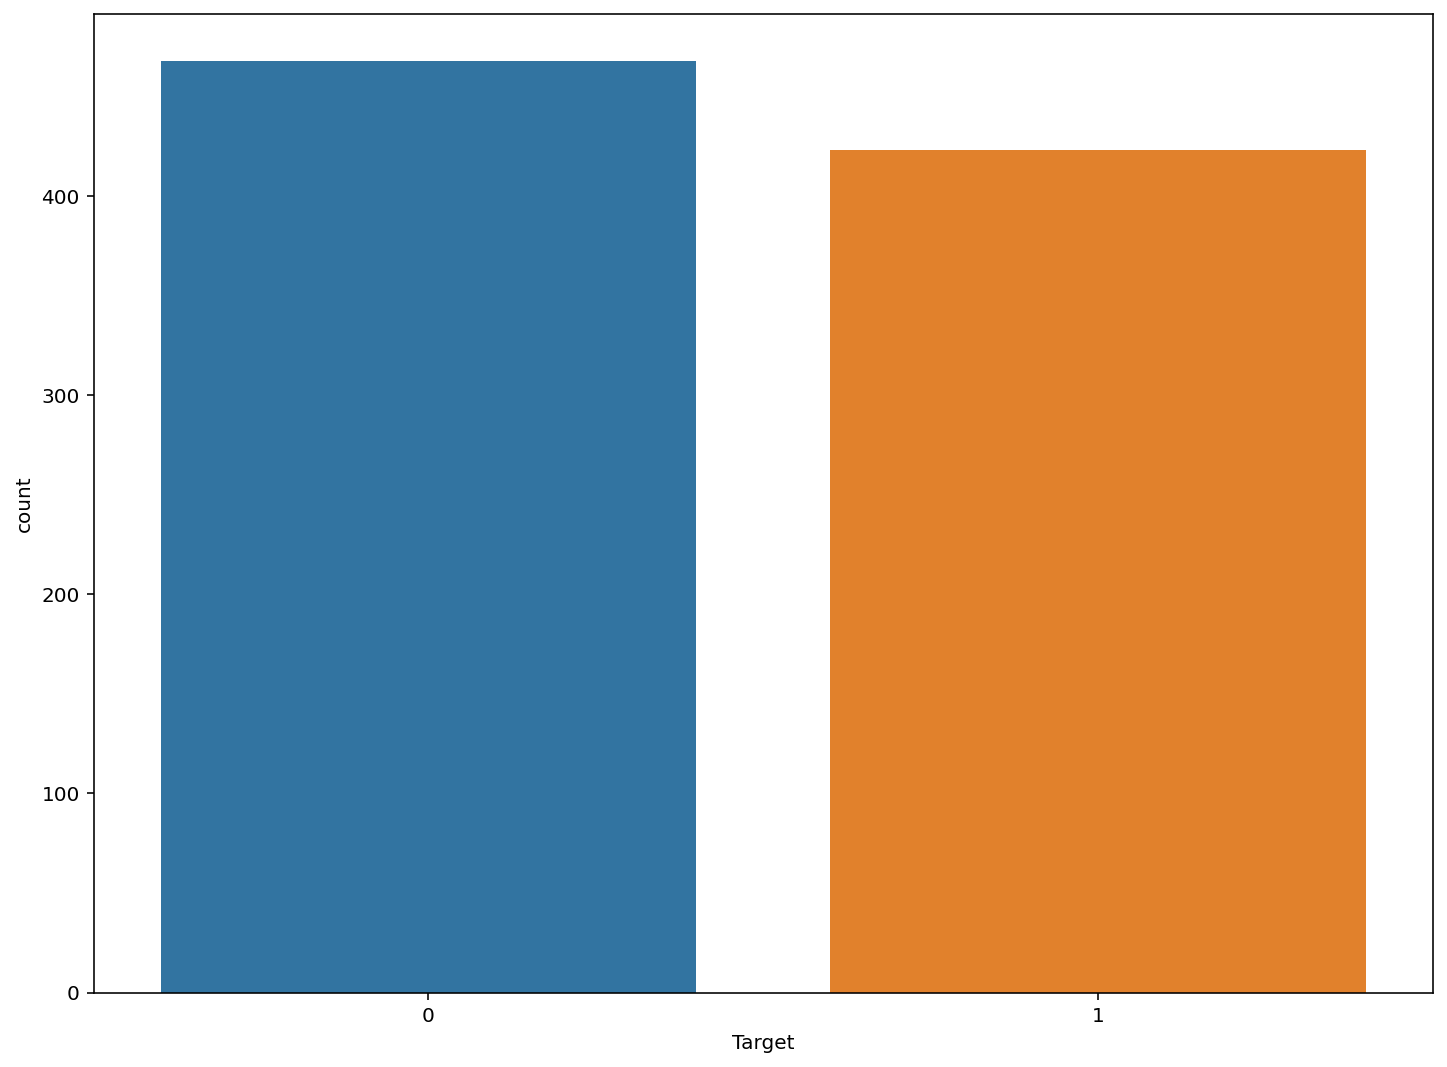

In [26]:
sns.countplot(x='Target', data = df);  # our data is balanced

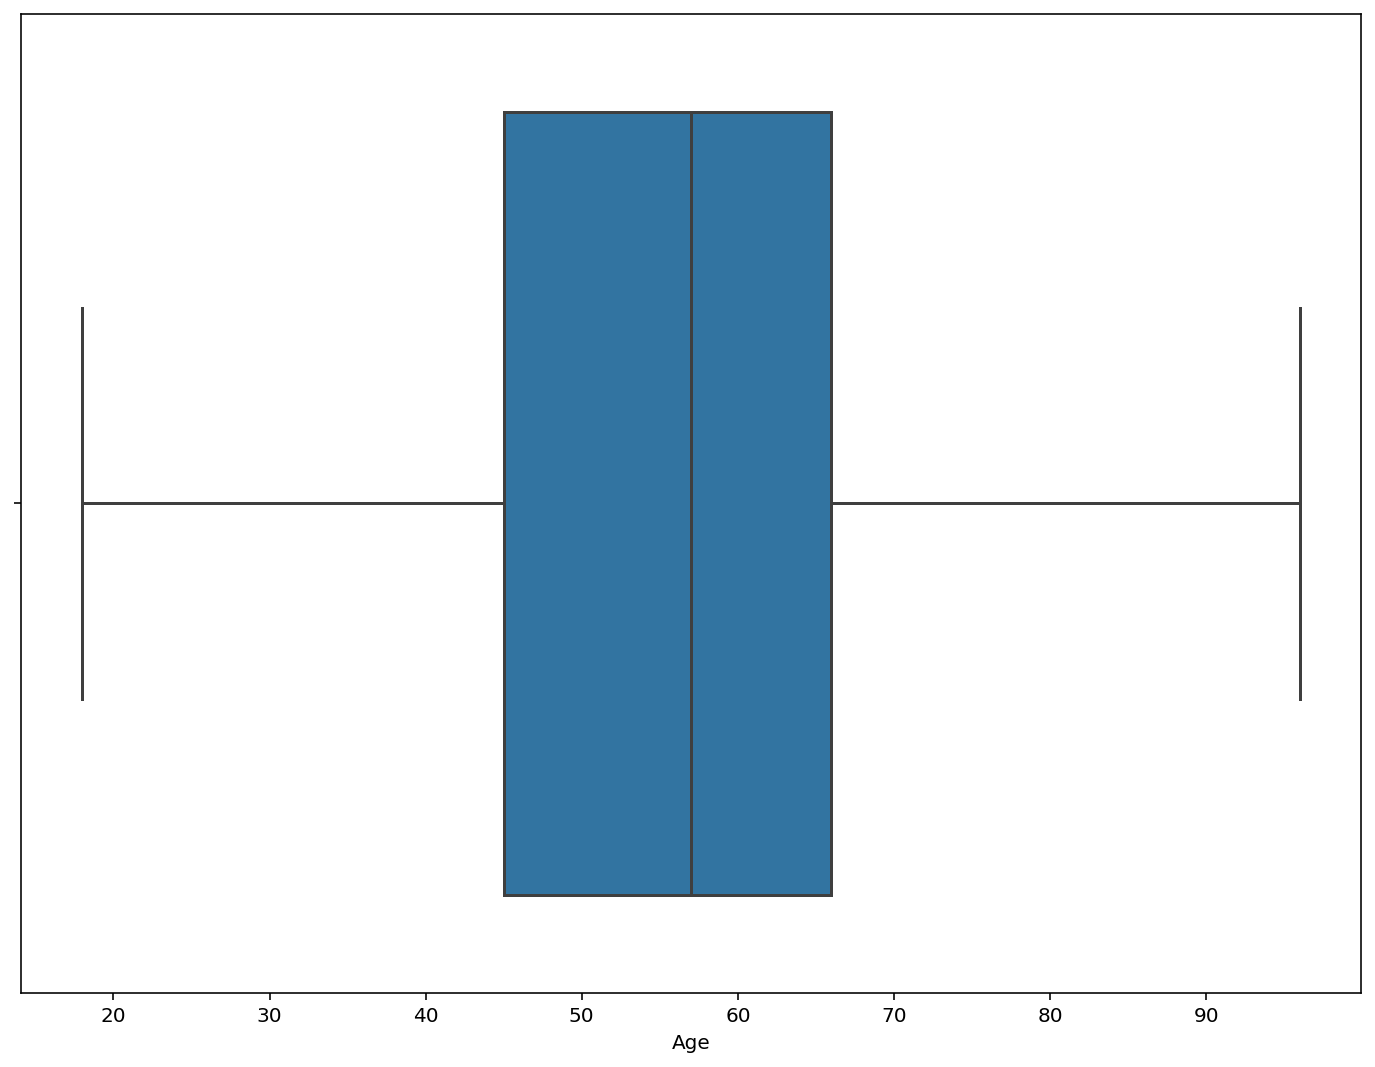

In [27]:
sns.boxplot(x=df.Age);

In [28]:
# sns.boxplot(x=df.Density); # we checked it and we dropped it

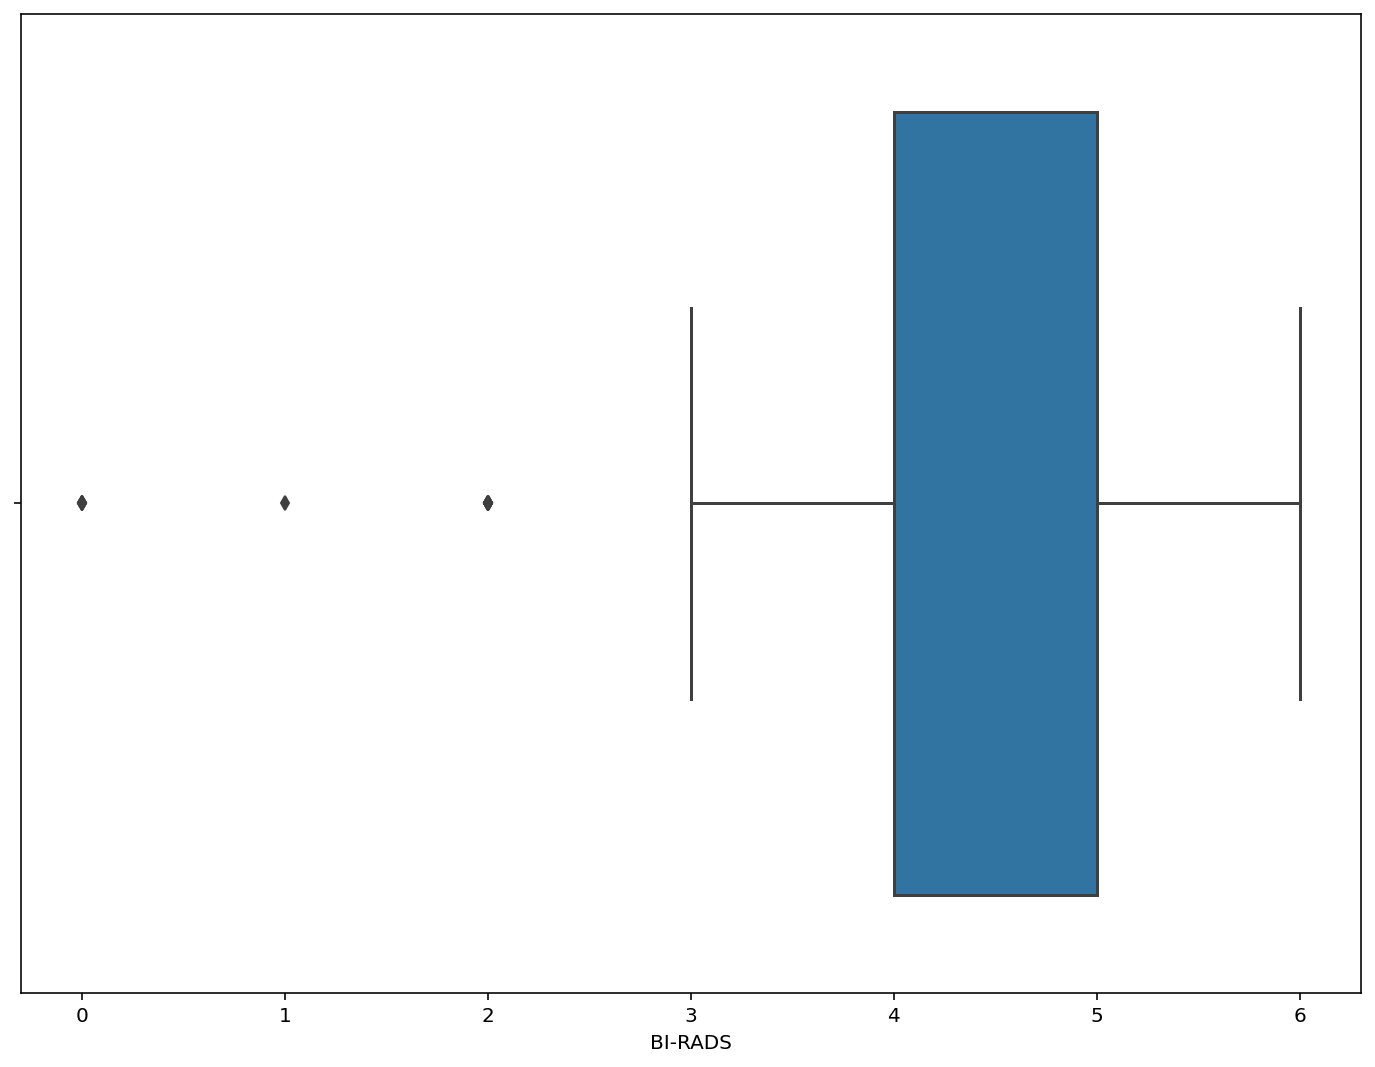

In [29]:
sns.boxplot(x=df['BI-RADS']); # we saw the extreme outlier here also!

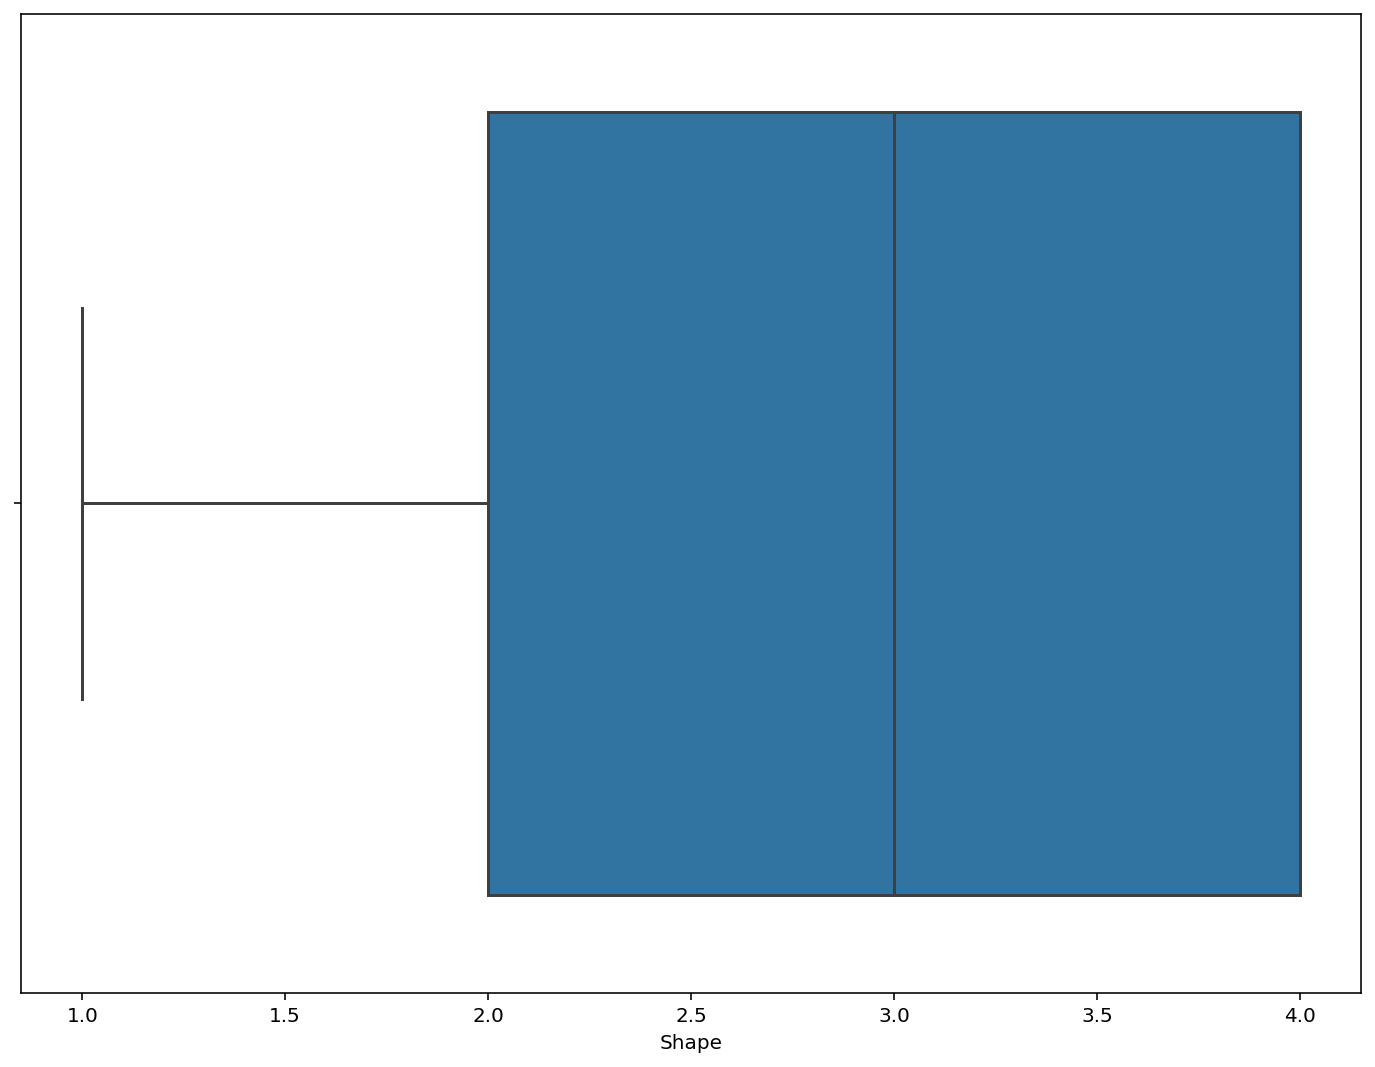

In [30]:
sns.boxplot(x=df['Shape']);

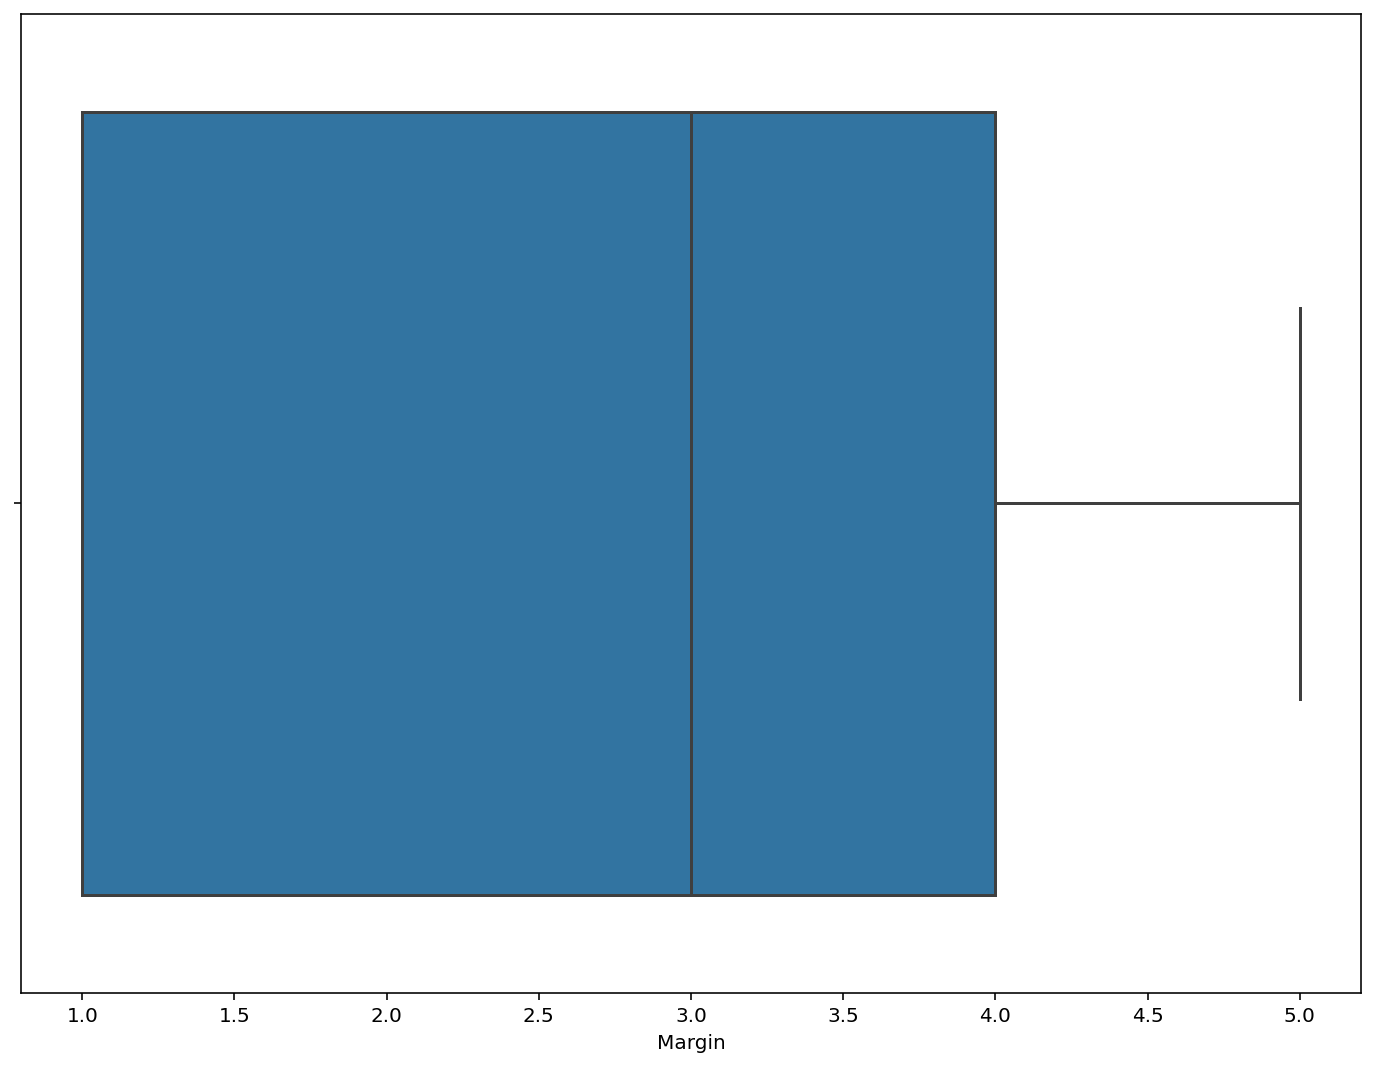

In [31]:
sns.boxplot(x=df['Margin']);

In [32]:
fig = px.scatter_matrix(df, color='Target')
fig

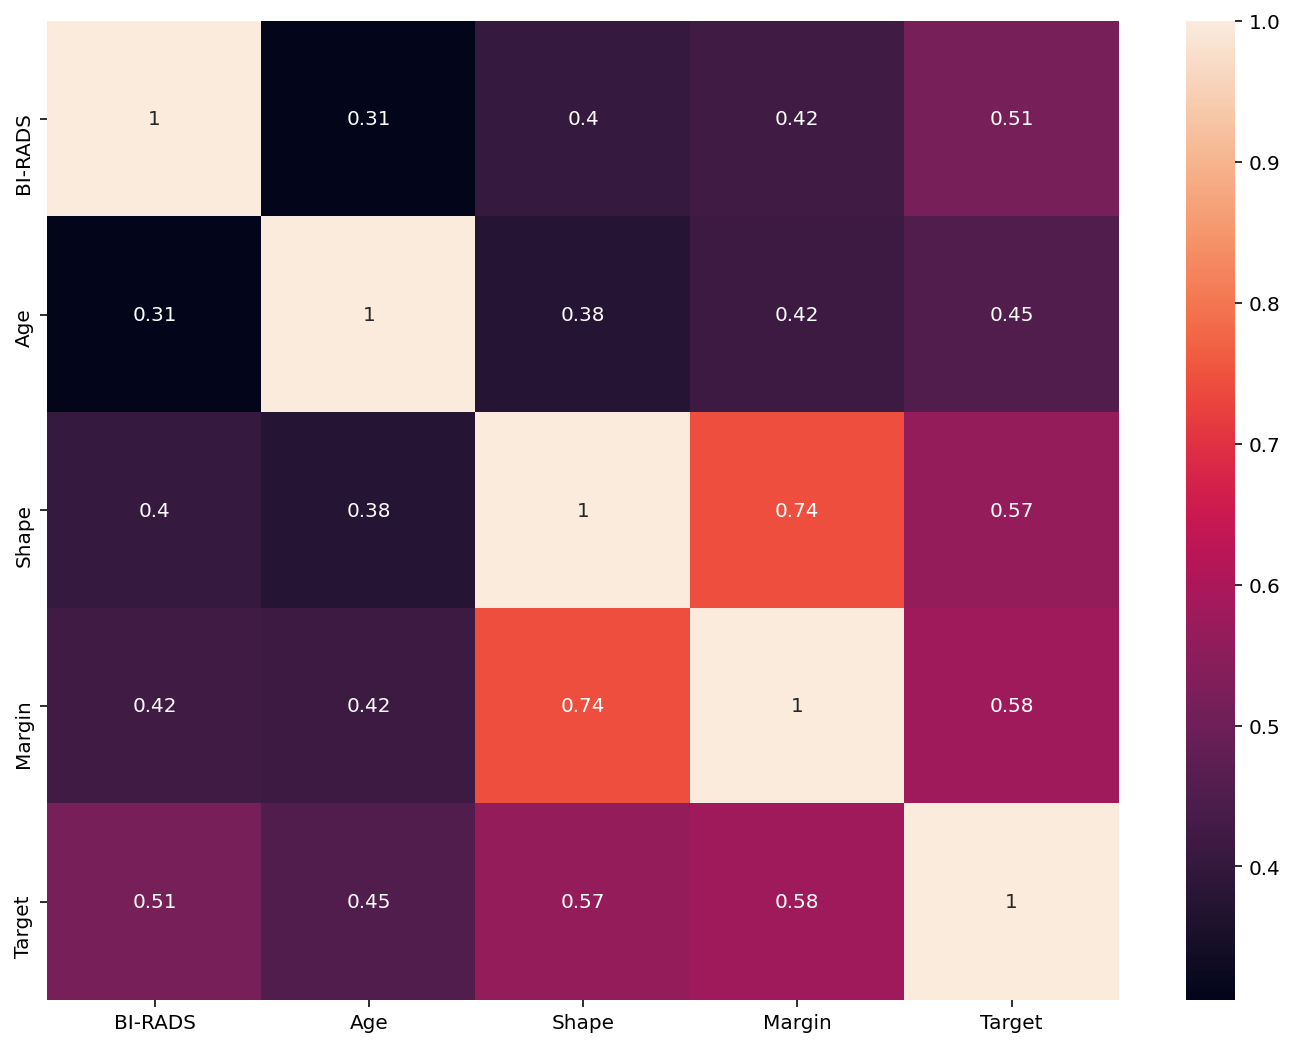

In [33]:
sns.heatmap(df.corr(), annot = True);

# *Train-Test-Split*

In [34]:
X = df.drop("Target",axis=1)
y = df["Target"]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## LogisticRegression

In [36]:
logreg=LogisticRegression()

In [37]:
logreg.fit(X_train,y_train)

LogisticRegression()

In [38]:
y_pred=logreg.predict(X_test)

In [39]:
logreg_f1 = f1_score(y_test, y_pred, average='macro')
logreg_f1

0.8374816067123759

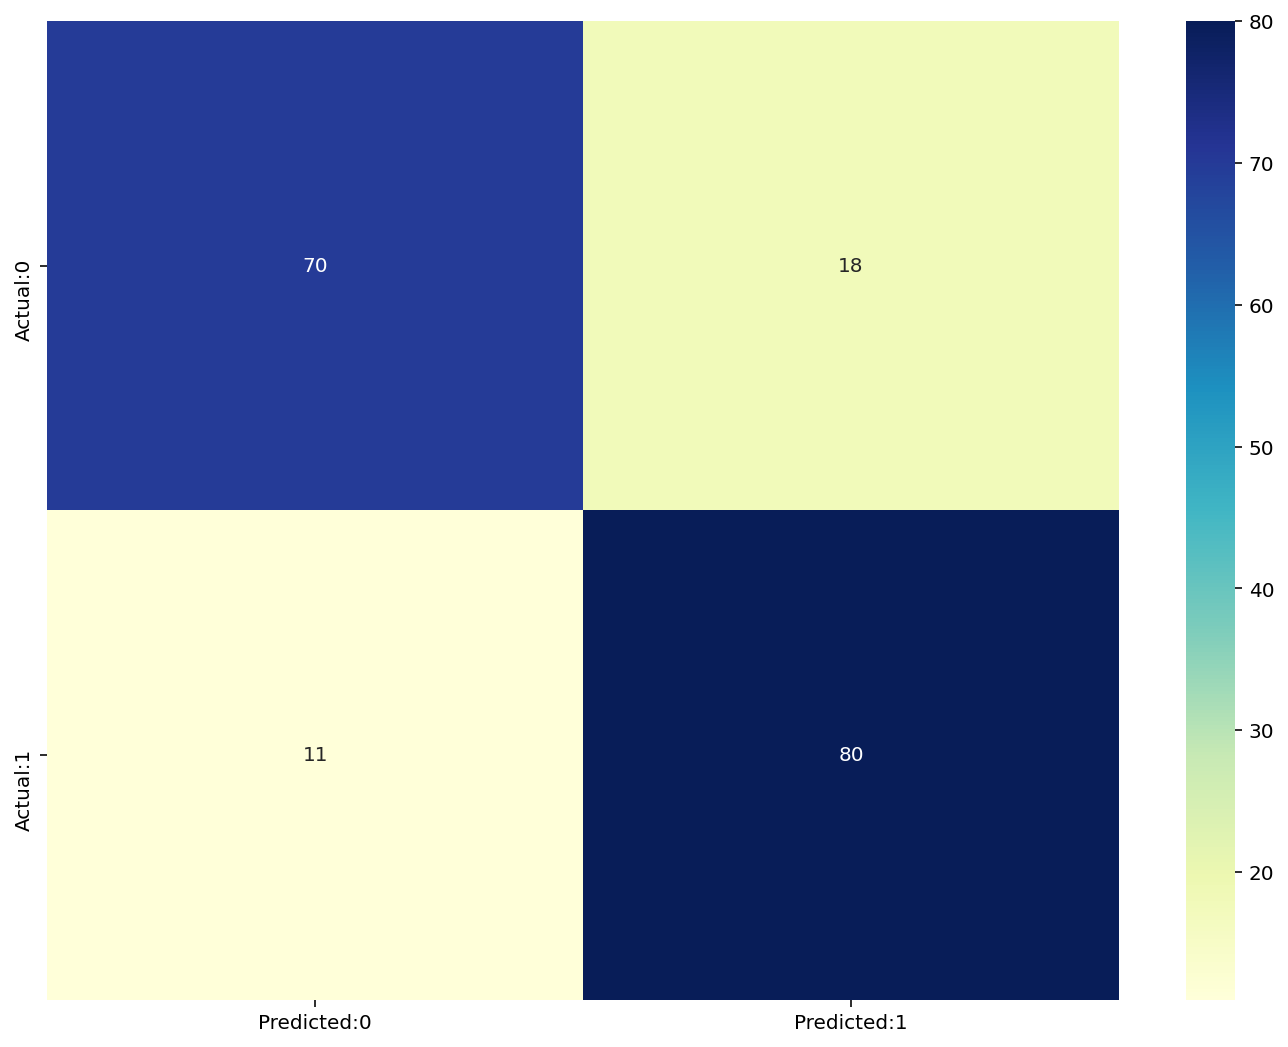

In [40]:
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        88
           1       0.82      0.88      0.85        91

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179



## XGBoost (with tuning)

In [94]:
xgb = XGBClassifier()

In [95]:
xgb_params = {"n_estimators": [50, 100, 300],
             "subsample":[0.5,0.8,1],
             "max_depth":[3,5,7],
             "learning_rate":[0.1,0.01,0.3]}

In [96]:
xgb_cv_model = GridSearchCV(xgb, xgb_params, cv = 2, 
                            n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


In [97]:
xgb_cv_model.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}

In [98]:
xgb_tuned = XGBClassifier(learning_rate= 0.01, 
                                max_depth= 3, 
                                n_estimators= 25, 
                                subsample= 0.5).fit(X_train, y_train)

In [99]:
y_pred = xgb_tuned.predict(X_test)

In [100]:
xgb_f1 = f1_score(y_test, y_pred, average='macro')
xgb_f1

0.8268156424581005

In [101]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83        88
           1       0.84      0.81      0.83        91

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



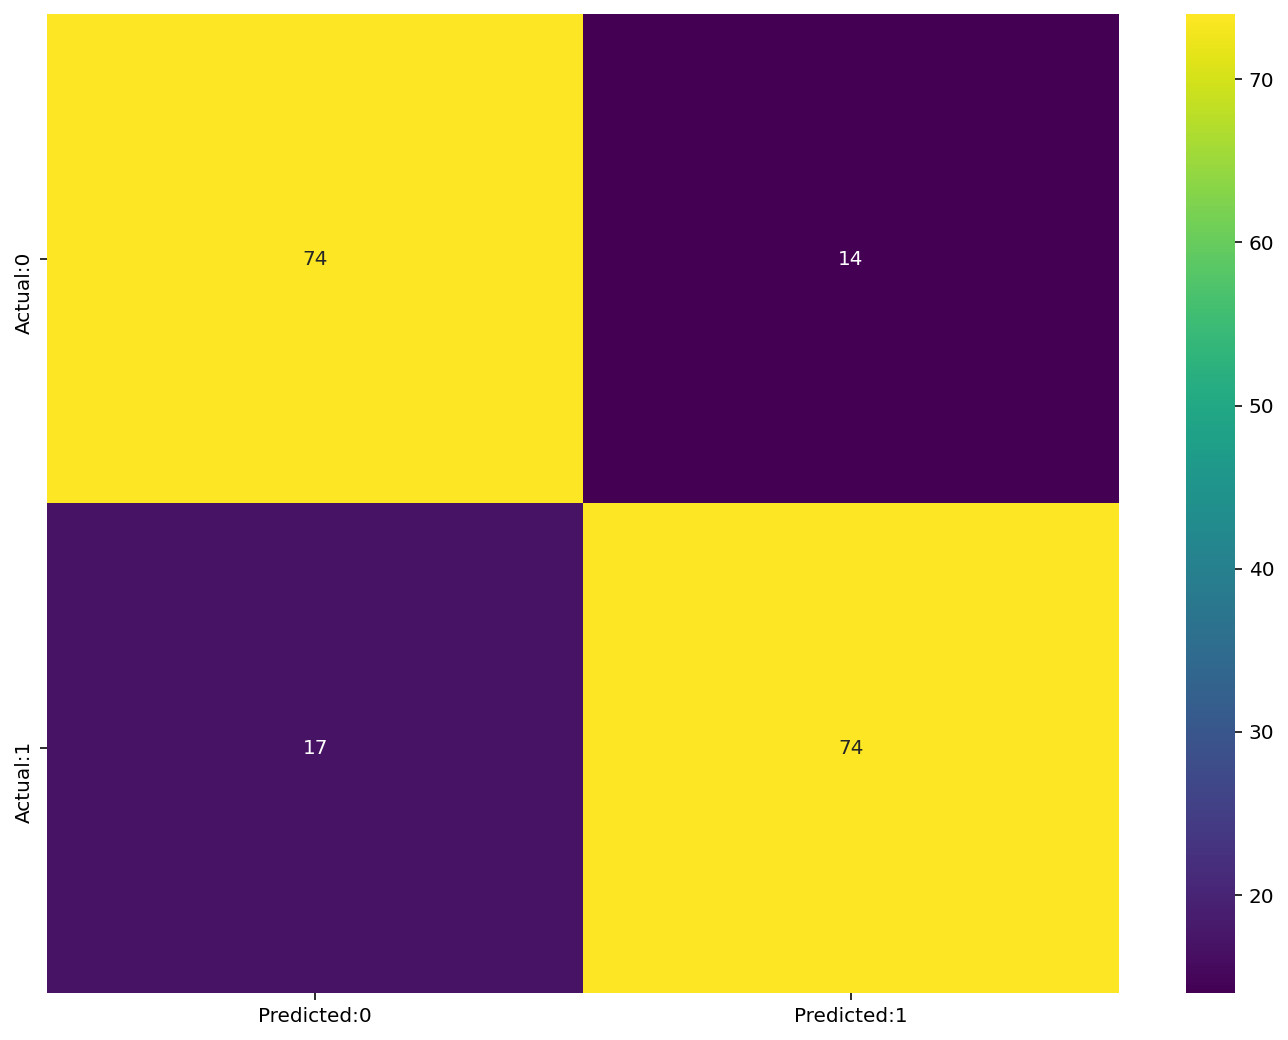

In [102]:
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="viridis");

## RandomForest (with tuning)

In [109]:
rf_m = RandomForestClassifier()

In [110]:
rf_params = {"n_estimators":[50, 100, 300],
              "max_depth":[3,5,7],
              "max_features": [2,4],
              "min_samples_split": [2,4,6]}

In [111]:
rf_cv_model = GridSearchCV(rf_m, rf_params, cv = 10, n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [112]:
rf_cv_model.best_params_

{'max_depth': 5, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 50}

In [113]:
rf_tuned = RandomForestClassifier(max_depth = 5,             
                                  max_features = 2, 
                                  min_samples_split = 2, 
                                  n_estimators = 50).fit(X_train, y_train)

In [114]:
y_pred_rf_tuned = rf_tuned.predict(X_test)

In [115]:
rf_f1 = f1_score(y_test, y_pred, average='macro')
rf_f1

0.8268156424581005

In [116]:
print(classification_report(y_test, y_pred_rf_tuned))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82        88
           1       0.83      0.84      0.83        91

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



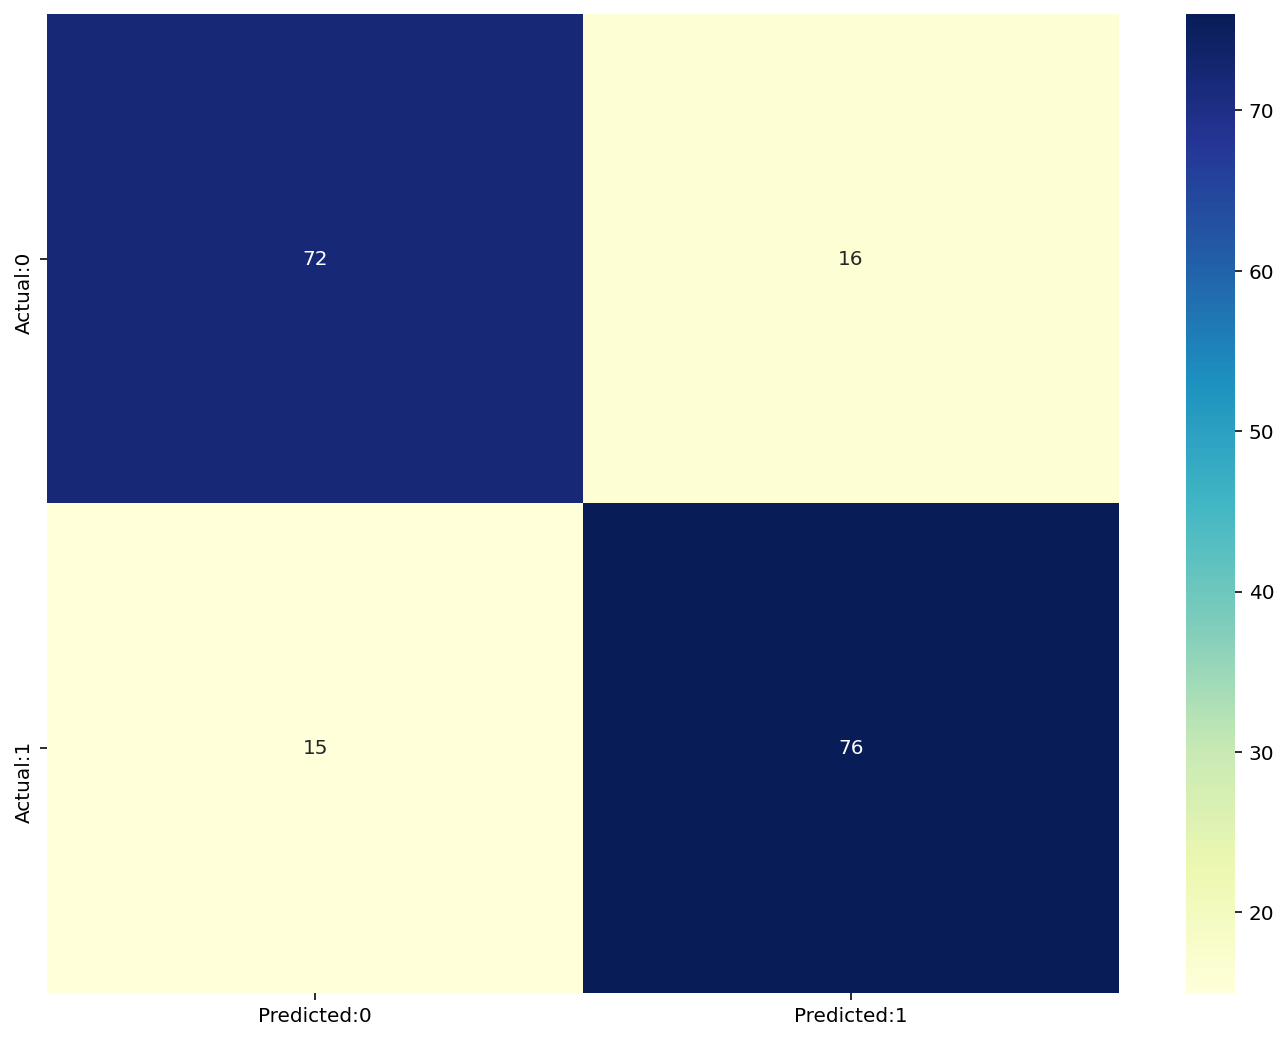

In [117]:
cm=confusion_matrix(y_test,y_pred_rf_tuned)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

# DecisionTree

In [60]:
dc_tr = DecisionTreeClassifier()

In [61]:
dc_tr.fit(X_train, y_train)

DecisionTreeClassifier()

In [62]:
y_pred = dc_tr.predict(X_test)

In [63]:
dctr_f1 = f1_score(y_test, y_pred, average='macro')
dctr_f1

0.815619440022474

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        88
           1       0.84      0.79      0.81        91

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179



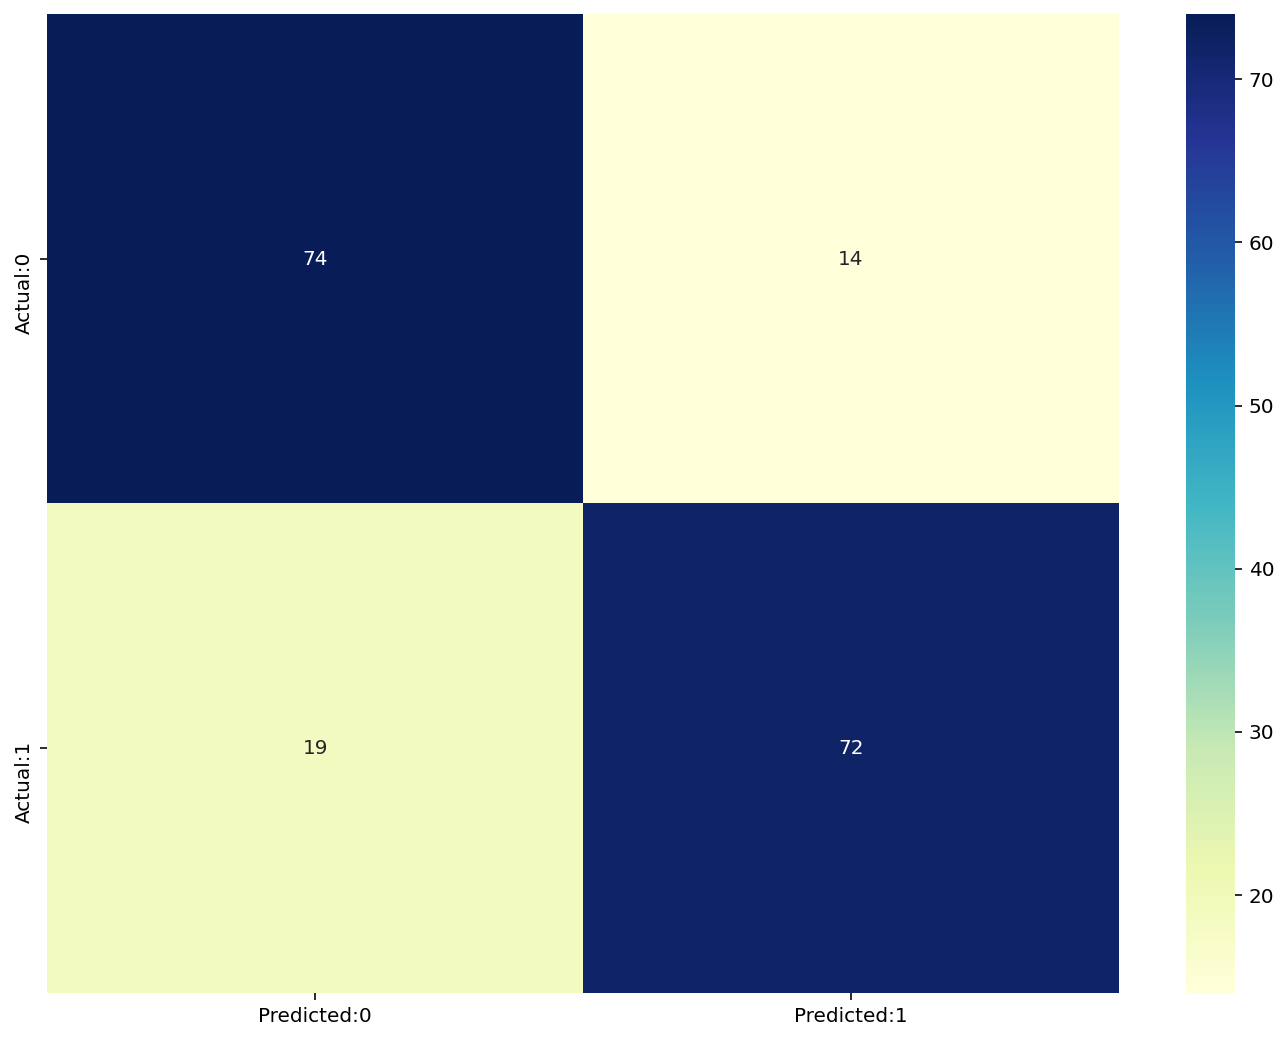

In [65]:
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

## SVM

In [66]:
svc = SVC()

In [67]:
svc.fit(X_train,y_train)

SVC()

In [68]:
y_pred= svc.predict(X_test)

In [69]:
svc_f1 = f1_score(y_test, y_pred, average='macro')
svc_f1

0.7873843460865217

In [70]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78        88
           1       0.78      0.81      0.80        91

    accuracy                           0.79       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.79      0.79      0.79       179



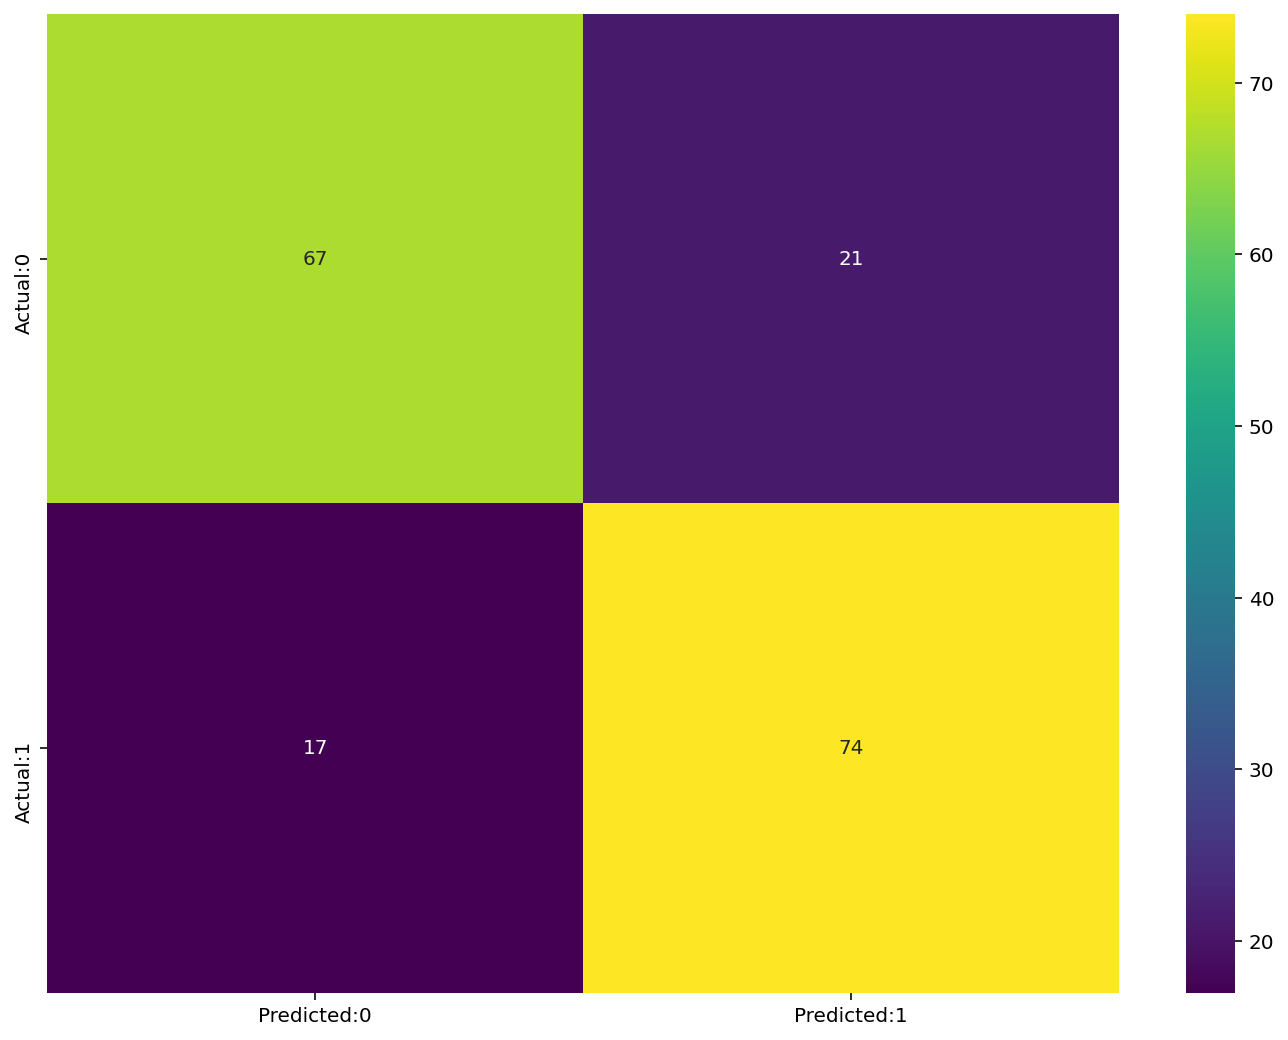

In [71]:
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="viridis");

In [72]:
## Scaling
scaler = StandardScaler()

In [73]:
X_train_s= scaler.fit_transform(X_train)

In [74]:
X_test_s = scaler.transform(X_test)

In [75]:
svm_model =SVC().fit(X_train_s,y_train)

In [76]:
y_pred=svm_model.predict(X_test_s)

In [77]:
svc_f1_sc = f1_score(y_test, y_pred, average='macro')
svc_f1_sc

0.821223470661673

In [78]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82        88
           1       0.83      0.81      0.82        91

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179



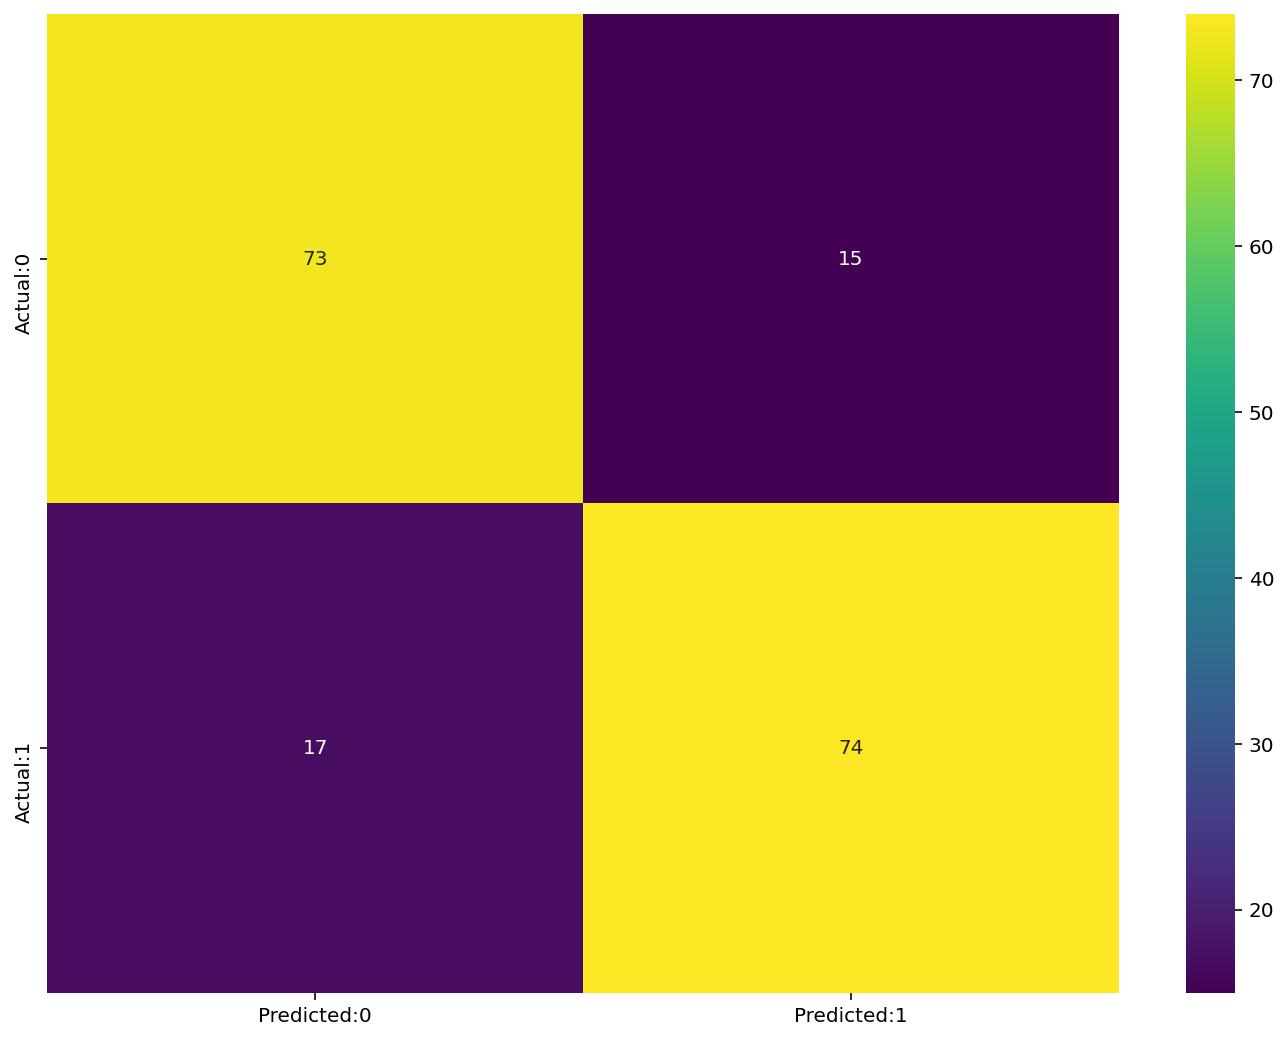

In [79]:
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="viridis");

## KNN (needs scaling)

In [80]:
scaler = StandardScaler()

In [81]:
scaler.fit(df.drop('Target', axis=1))

StandardScaler()

In [82]:
scaled_x = scaler.transform(df.drop('Target', axis=1))

In [83]:
df_scaled = pd.DataFrame(scaled_x, columns=df.columns[:-1])

In [84]:
X = df_scaled

In [85]:
y = df['Target']

In [86]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [87]:
def my_accuracy(y_test,y_pred):
    acc = accuracy_score(y_true=y_test, y_pred=y_pred)
    print('Acc: {:.4f}'.format(acc))

In [88]:
def KNN_loop(x_train,y_train,x_test,MAX):
    
    # Loop MAX times
    for i in range(MAX):
        # Create the corresponding KNN Classifier 
        KNeighClf = KNeighborsClassifier(n_neighbors=i+1)
        
        # Fit and predict the model
        KNN = KNeighClf.fit(X_train, y_train)
        y_pred = KNN.predict(X_test)
        
        # Display the results
        # my_confusion_matrix(y_test, y_pred)
        print ("Neighbors = " + str(i+1))
        my_accuracy(y_test,y_pred)

KNN_loop(X_train,y_train,y_test,25)

Neighbors = 1
Acc: 0.7654
Neighbors = 2
Acc: 0.7430
Neighbors = 3
Acc: 0.8045
Neighbors = 4
Acc: 0.8045
Neighbors = 5
Acc: 0.8101
Neighbors = 6
Acc: 0.8156
Neighbors = 7
Acc: 0.8212
Neighbors = 8
Acc: 0.8045
Neighbors = 9
Acc: 0.8156
Neighbors = 10
Acc: 0.8045
Neighbors = 11
Acc: 0.8101
Neighbors = 12
Acc: 0.8045
Neighbors = 13
Acc: 0.8045
Neighbors = 14
Acc: 0.8045
Neighbors = 15
Acc: 0.8045
Neighbors = 16
Acc: 0.8156
Neighbors = 17
Acc: 0.8101
Neighbors = 18
Acc: 0.8101
Neighbors = 19
Acc: 0.7989
Neighbors = 20
Acc: 0.8101
Neighbors = 21
Acc: 0.8101
Neighbors = 22
Acc: 0.8156
Neighbors = 23
Acc: 0.8045
Neighbors = 24
Acc: 0.8045
Neighbors = 25
Acc: 0.8045


In [89]:
# KNN with K=7 seems the best fit
# Run it again with full results this time
KNeighClf = KNeighborsClassifier(7)
KNN = KNeighClf.fit(X_train, y_train)

y_pred = KNN.predict(X_test)

In [90]:
knn_f1 = f1_score(y_test, y_pred, average='macro')
knn_f1

0.8210894552723639

In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82        88
           1       0.82      0.84      0.83        91

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179



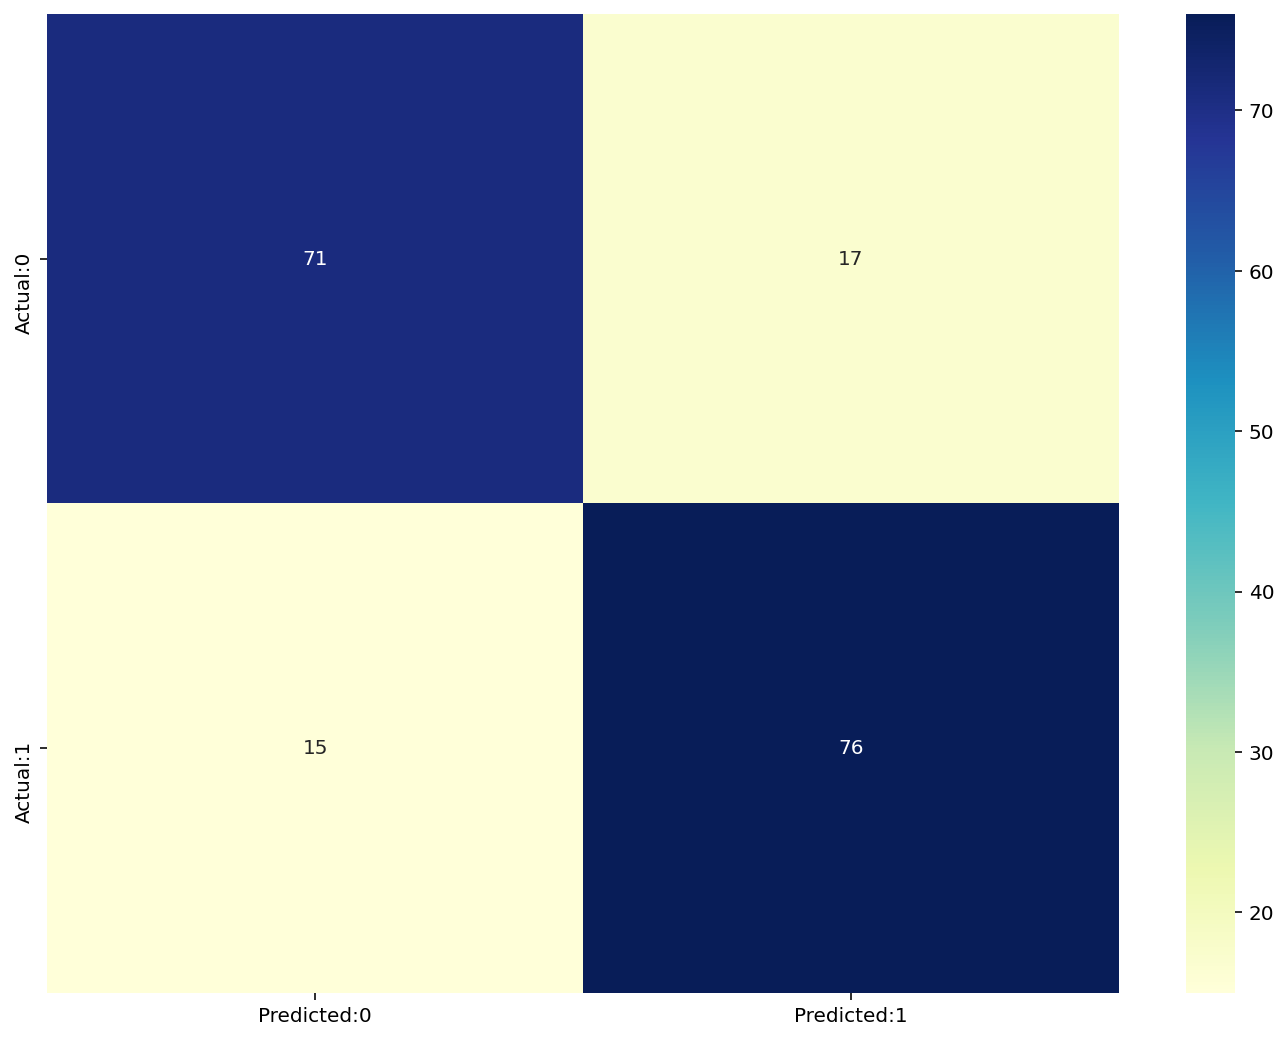

In [92]:
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

## Model Comparison 

Text(0.5, 1.0, 'F1 Score of Different Models')

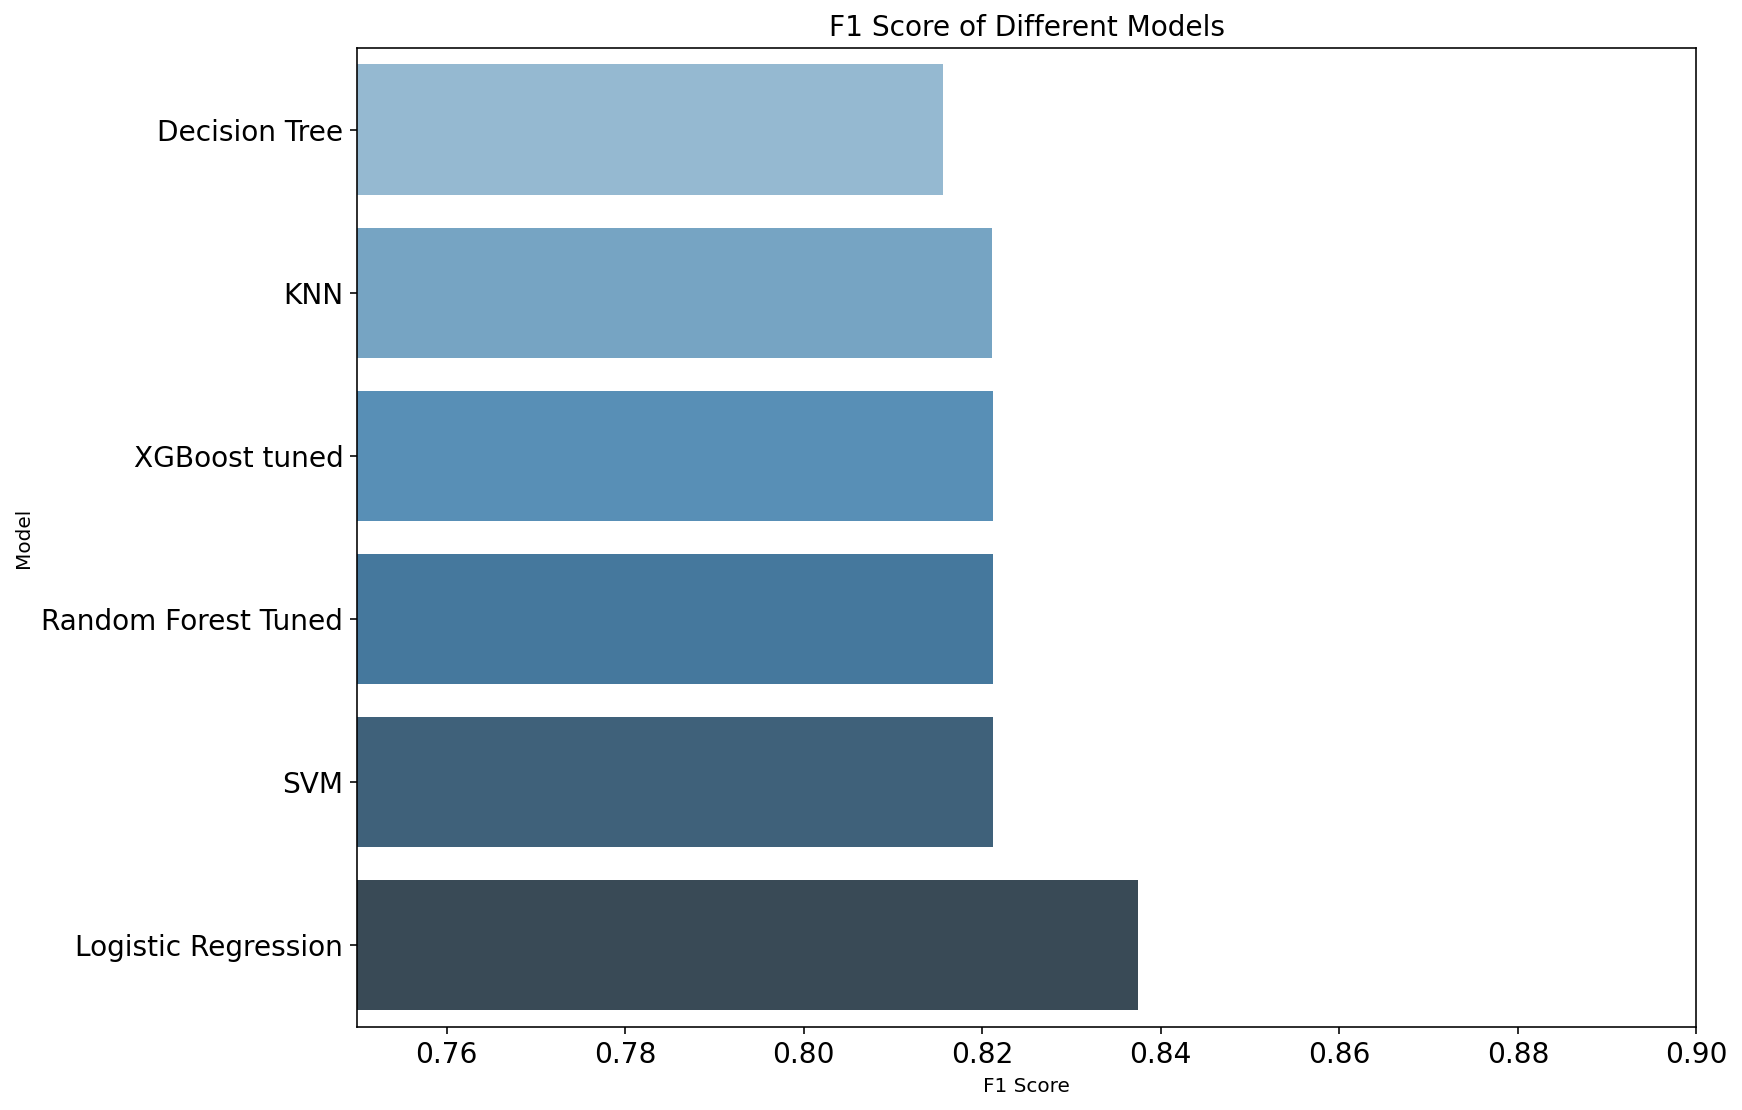

In [93]:
compare = pd.DataFrame({"Model": ["Logistic Regression","XGBoost tuned",
                                  "Random Forest Tuned","Decision Tree", "SVM","KNN"],
                        "F1 Score": [logreg_f1, xgb_f1, rf_f1,dctr_f1,svc_f1_sc,knn_f1]})

compare = compare.sort_values(by="F1 Score", ascending=True)

ax = sns.barplot(x="F1 Score", y="Model", data=compare, palette="Blues_d")
ax.set_xlim(.75, .90)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.title("F1 Score of Different Models", size=14)